# Conservation Analysis and Epitope Prediction


#### Author: C. Mazzaferro, K. Fisch
#### Email: cmazzafe@ucsd.edu
#### Date: October 2016
 
## Outline of Notebook
<a id = "toc"></a>
1. <a href = "#background">Background</a>
2. <a href = "#Cons">High Affinity Binding Prediction </a>
    * <a href = "#Agg">Data Aggregation</a>
    * <a href = "#Sim">Similarty Score Calculation</a>
    * <a href = "#Plot">Visualize</a>

Directions (from Mali's e-mail sent a couple of weeks ago):

Determine Cas9 orthologs that are orthogonal in the 'immunogenicity space'. This will allow us to prescribe a sequential regimen of Cas9s for therapeutic interventions. I've been thinking some more about how to do this, and I believe a simple strategy as follows might work:

- step i: build a database of Cas9 orthologs; #n.
- step ii: pick a seed Cas9 ortholog, say Sp, and then do a pairwise alignment with every other ortholog (n-1 alignments total). note that aligning all together will not be useful for our objective.
- step iii: overlay the immunogenicity profiles and score direct peptide overlaps (adding +1 for each overlap and 0 otherwise). sum the scores and retain orthologs (#m) for which the summation score = 0.
- step iv: randomly pick a second Cas9 from the orthologs retained in step iii and iterate back to step ii but now do just m-1 alignments with the retained orthologs. 

This should quickly converge and give a handful of orthologs. We should ideally be able to dial the immunogenicity thresholds in the workflow as we could potentially land up with too many or too few options. We might also get different orthogonal lists based on the choice of seed ortholog -- but their should still be substantial overlaps, and so we should ideally iterate through all orthologs in step i to establish robustness of the lists.

This is just a suggestion for a potential workflow, so let me know what you'll think and absolutely feel free to pick this apart!


<a id = "background"></a>
# Background

CRISPR (clustered regularly interspaced short palindromic repeat) is an adaptive immune system that provides protection against mobile genetic elements (viruses, transposable elements and conjugative plasmids).
CRISPR clusters contain spacers, sequences complementary to antecedent mobile elements, and target invading nucleic acids. CRISPR clusters are transcribed and processed into CRISPR RNA (crRNA). In type II CRISPR systems correct processing of pre-crRNA requires a trans-encoded small RNA (tracrRNA), endogenous ribonuclease 3 (rnc) and this protein. The tracrRNA serves as a guide for ribonuclease 3-aided processing of pre-crRNA; Cas9 only stabilizes the pre-crRNA:tracrRNA interaction and has no catalytic function in RNA processing. Subsequently Cas9/crRNA/tracrRNA endonucleolytically cleaves linear or circular dsDNA target complementary to the spacer; Cas9 is inactive in the absence of the 2 guide RNAs (gRNA). The target strand not complementary to crRNA is first cut endonucleolytically, then trimmed 3'-5' exonucleolytically. DNA-binding requires protein and both gRNAs, as does nuclease activity. Cas9 recognizes the protospacer adjacent motif (PAM) in the CRISPR repeat sequences to help distinguish self versus nonself, as targets within the bacterial CRISPR locus do not have PAMs. DNA strand separation and heteroduplex formation starts at PAM sites; PAM recognition is required for catalytic activity (PubMed:24476820). Confers immunity against a plasmid with homology to the appropriate CRISPR spacer sequences (CRISPR interference) (PubMed:21455174)

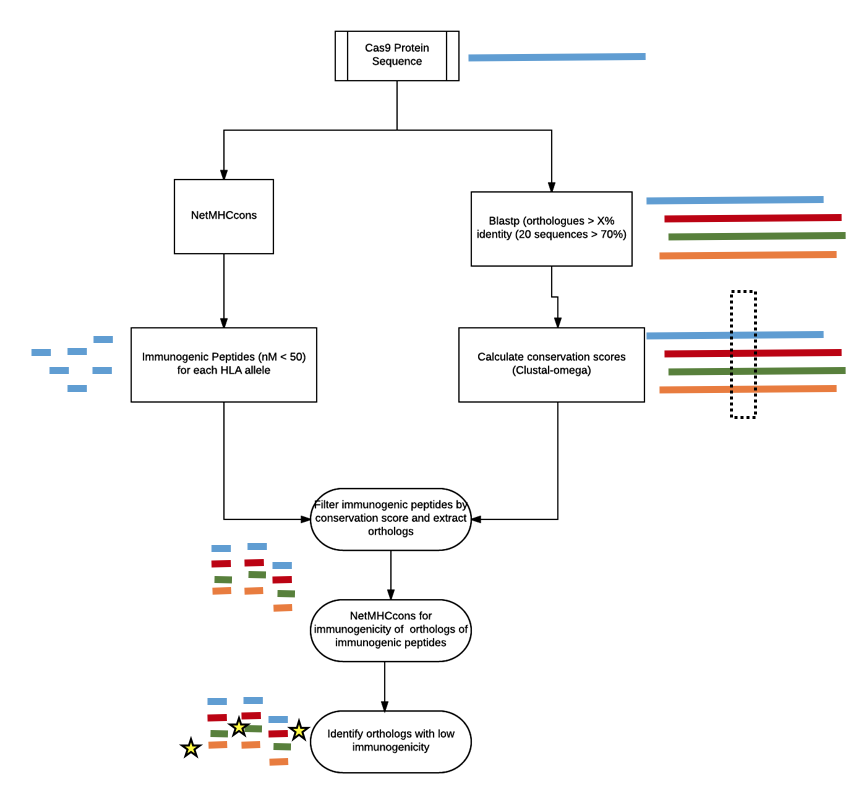

In [96]:
from IPython.display import Image
Image("/Users/carlomazzaferro/Desktop/BINF Int Rand Pics/workflow_epitope.png")

The pipeline presented here is aimed at identify the most immunogenic peptides in Cas9. By looking at multiple sequence alignment scores for the possible peptides and their associated predicted MHC affinity, we can determine which peptides within a Cas9 orthologue can be swapped in order to reduce overall immunogenecity.

The steps are constructed as follows: 

1. Select proteins [from reference papaer](http://nar.oxfordjournals.org/content/suppl/2013/10/29/gkt1074.DC1/nar-02672-z-2013-File008.pdf)
2. Predict the MHC affinity of each peptide using [CBS's prediction services](http://www.cbs.dtu.dk/services/), in particular [netMHCcons Server](http://www.cbs.dtu.dk/services/NetMHCcons/)
3. Rank proteins according to their similarity bases on a seed*

*See attached file: `workflow_and_results.txt` for a lengthier description of how the scoring was done

<a id = "Cons"></a>
# MHC Binding Affinity Prediction 
### Ran on netMHCcons for n-mers of 8, 9, 10, 11 amino acids and for the 12 allele supertype families

Run for each protein sequence retrieved from reference paper.

In [50]:
import importlib
from nepitope import net_MHC_interface
importlib.reload(net_MHC_interface)

all_alleles = ['HLA-A0101','HLA-A0201','HLA-A0301','HLA-A2402','HLA-A2601',
               'HLA-B0702','HLA-B0801','HLA-B2705','HLA-B3901','HLA-B4001','HLA-B5801','HLA-B1501']
nmer_list = [8,9,10,11]


fasta_file = '/Users/carlomazzaferro/Desktop/PROJECT_LOC_TEST/prots_in_fasta.fasta'
net_mhc_path = '/Users/carlomazzaferro/Desktop/BINF_Tools/netMHC-4.0/netMHC'

net_mhc = net_MHC_interface.netMHCComand(net_mhc_path, fasta_file, nmer_list, all_alleles)

In [3]:
net_mhc.create_text_command()

'netMHC commands written to run_netMHC.txt located at /Users/carlomazzaferro/Desktop/Test_Workflow_From_Scratch/mhc_preds_fasta_from_study_dealigned'

## Load file

In [135]:
from nepitope import mhc_utils
import pandas
import glob
import importlib
importlib.reload(mhc_utils)
#files saved from netMHC in  multiple different files, one per each query (nmer, allele)
filepath = '/Users/carlomazzaferro/Desktop/Test_IEDB/OtherProtsPrashant/mhc_preds/'

aggregate_all = mhc_utils.FileConsolidation(filepath, fasta_file)

In [136]:
#returns a dataframe per file used (just one in this case)
df_list = aggregate_all.return_df_list()

In [137]:
#Would run this. But too slow. The 3 cells below are speed-optimized. 
lsss_1 = aggregate_all.optimized_list_df_by_prot(df_list)

/Users/carlomazzaferro/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [116]:
sss = pandas.concat(lsss_1)
high_int_aa = sss.loc[sss['Affinity Level'] ==  ('High' or 'Intermediate')]
high_int_aa.to_csv('/Users/carlomazzaferro/Desktop/Test_IEDB/OtherProtsPrashant/high_aa_all_prots.csv')

## Load original proteins

In [138]:
from nepitope import pairwise_comp
importlib.reload(pairwise_comp)

<module 'nepitope.pairwise_comp' from '/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/pairwise_comp.py'>

In [139]:
pwcomp = pairwise_comp.PairwiseComp(lsss_1, 5, fasta_file) 
df_pairwise_comps  = pwcomp.pipe_run() 

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/pairwise_comp.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['Peptide'] = df['Peptide'].str.replace('X', '-')


In [140]:
swaps_df_dir = '/Users/carlomazzaferro/Desktop/Test_IEDB/OtherProtsPrashant/swap_results/S__pyogenes_Cas9/summary_results_per_prediction.csv'
swaps_df = pandas.read_csv(swaps_df_dir)

In [149]:
from importlib import reload
reload(merge_workflows)
from nepitope import merge_workflows
merged = merge_workflows.MergeSwapsAndComp(df_pairwise_comps, swaps_df, 1)


/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/merge_workflows.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df = pandas.DataFrame(maximal_list)


In [150]:
mod_fasta = '/Users/carlomazzaferro/Desktop/Test_IEDB/OtherProtsPrashant/merged_worflow_files/mod_fasta.fasta'
orig_fasta = '/Users/carlomazzaferro/Desktop/PROJECT_LOC_TEST/prots_in_fasta.fasta'
merged.get_modified_fasta(orig_fasta, mod_fasta)

In [151]:
ls_mod = merged.get_modified_df_list(lsss_1)


{'LTFRIPYYV': 'LWFRIPYYV'}
Int64Index([443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443], dtype='int64')


In [152]:
pwcomp_1_swap = pairwise_comp.PairwiseComp(ls_mod, 5, mod_fasta)

/Users/carlomazzaferro/Documents/Code/neoantigen/antigen_discovery/nepitope/pairwise_comp.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['Peptide'] = df['Peptide'].str.replace('X', '-')


In [154]:
df_1_swap = pwcomp_1_swap.pipe_run()

In [156]:
df_1_swap.to_csv('/Users/carlomazzaferro/Desktop/Test_IEDB/OtherProtsPrashant/single_swap_pairwise_comp.csv')